In [ ]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math


def plot_images(images, nrows=1, ncols=5, cmap='gray', figsize=(20, 10), filename=None):
    """
    Plot a list of images using matplotlib subplots.

    Args:
        images (list or np.ndarray): List or array of images to plot.
        nrows (int): Number of rows in the subplot grid.
        ncols (int): Number of columns in the subplot grid.
        cmap (str): Color map for the images (e.g., 'gray', 'viridis').
        figsize (tuple): Tuple specifying the overall figure size (width, height).
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Iterate through all the subplots
    for i, ax in enumerate(axes):
        if i < len(images):  # Plot if there are images left
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axes
        else:  # Turn off any extra axes (used when images < nrows*ncols)
            ax.axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


def show_reconstructions_code(model, images, shape, n_images=5, **kwargs):
    code = model.layers[0].predict(images[:n_images])
    code_images = code.reshape([n_images] + list(shape))
    reconstructed_images = model.layers[1].predict(code)
    # all_images = np.append(images, reconstructed_images, axis=0)
    all_images = [x for x in images[:n_images]]
    all_images.extend(code_images)
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=3, **kwargs)


def show_code_reconstructions(decoder, codes, n_images=5, shape=None):
    code_shape = (1, codes.shape[1])
    reconstructions = decoder.predict(codes[:n_images])
    reconstructed_images = reconstructions if shape is None else reconstructions.reshape([n_images] + list(shape))
    all_images = [x.reshape(code_shape) for x in codes]
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=2)


def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

2025-04-25 11:00:18.691110: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 11:00:18.719219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 11:00:18.845321: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 11:00:18.846293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
mkdir -p failed for path /.config/matplotlib: [Errno 13] Permission denied: '/.config'
Matplotlib crea

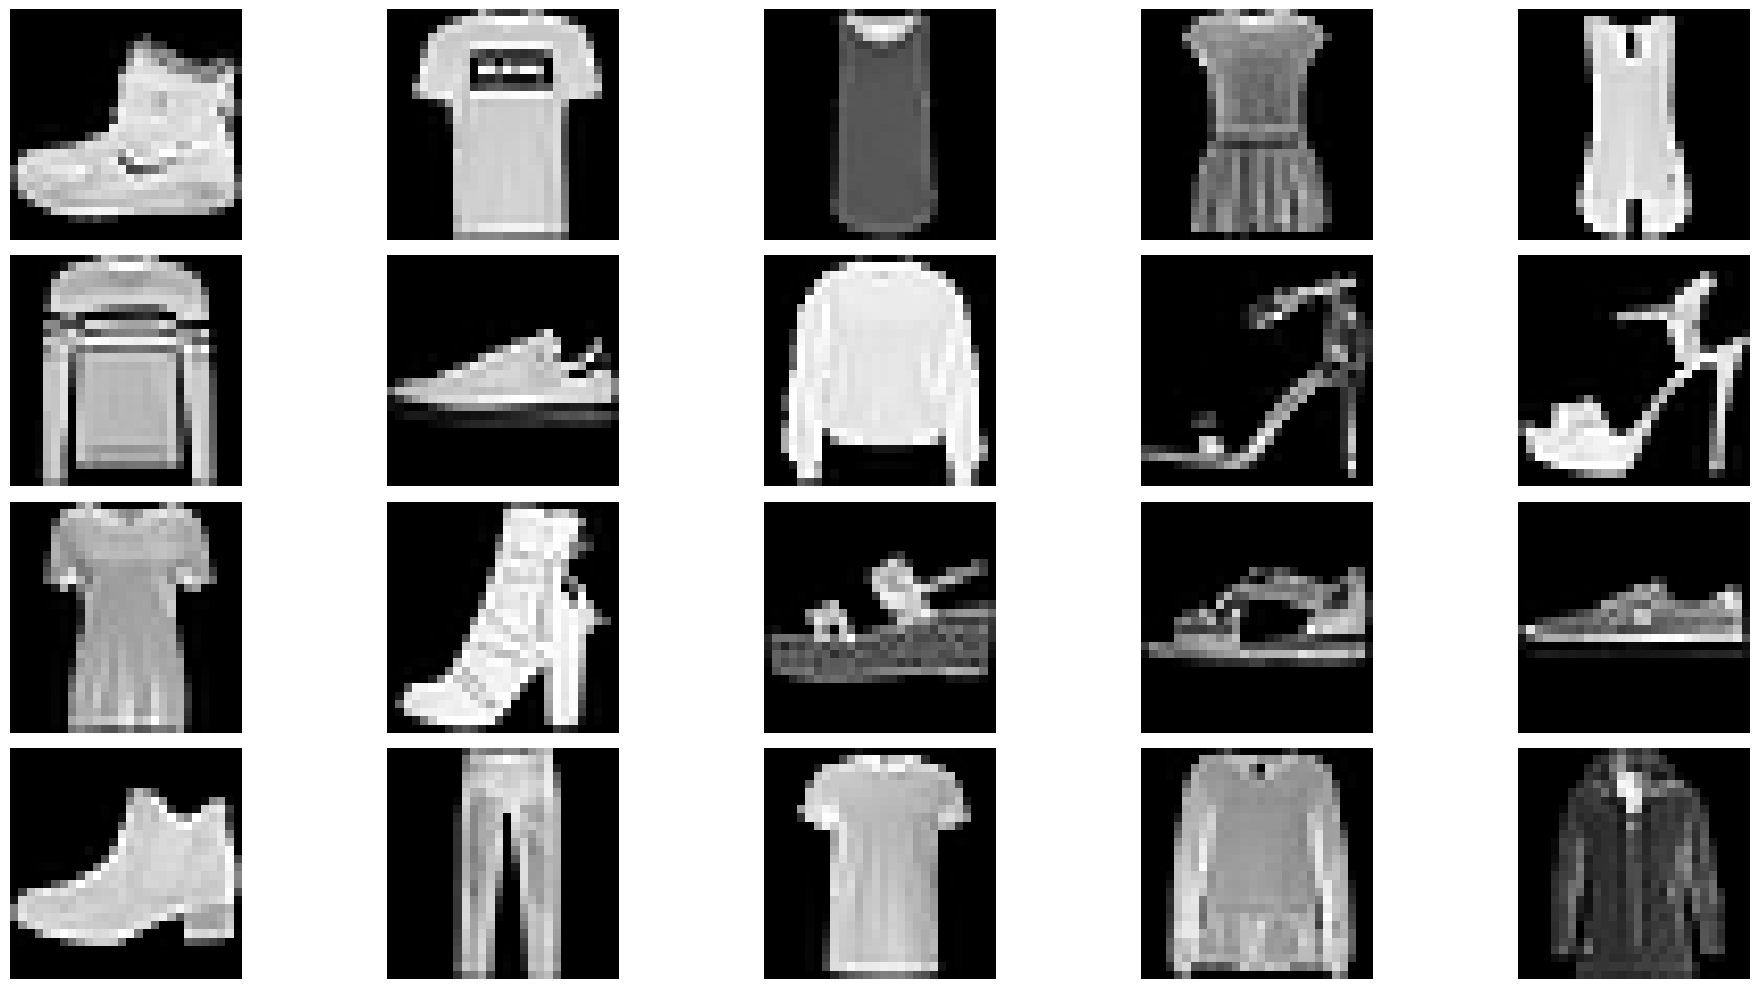

In [2]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

plot_images(X_train[:20], 4, 5)

In [3]:
base_model = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
base_model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    #optimizer="adam"
    metrics=["accuracy"]
)
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2025-04-25 11:00:22.545403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-25 11:00:22.578344: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
base_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 1s - loss: 0.8081 - accuracy: 0.7894 - val_loss: 0.8443 - val_accuracy: 0.8198 - 1s/epoch - 717us/step
Epoch 2/10
1719/1719 - 1s - loss: 0.8281 - accuracy: 0.8079 - val_loss: 1.0008 - val_accuracy: 0.8176 - 903ms/epoch - 525us/step
Epoch 3/10
1719/1719 - 1s - loss: 0.8117 - accuracy: 0.8151 - val_loss: 1.0196 - val_accuracy: 0.7712 - 913ms/epoch - 531us/step
Epoch 4/10
1719/1719 - 1s - loss: 0.8284 - accuracy: 0.8193 - val_loss: 0.9956 - val_accuracy: 0.7810 - 909ms/epoch - 529us/step
Epoch 5/10
1719/1719 - 1s - loss: 0.8491 - accuracy: 0.8186 - val_loss: 0.8525 - val_accuracy: 0.8260 - 921ms/epoch - 536us/step
Epoch 6/10
1719/1719 - 1s - loss: 0.8002 - accuracy: 0.8234 - val_loss: 0.7691 - val_accuracy: 0.8212 - 924ms/epoch - 537us/step
Epoch 7/10
1719/1719 - 1s - loss: 0.7997 - accuracy: 0.8219 - val_loss: 0.8338 - val_accuracy: 0.8212 - 960ms/epoch - 558us/step
Epoch 8/10
1719/1719 - 1s - loss: 0.8258 - accuracy: 0.8222 - val_loss: 0.7825 - val_accuracy: 0.826

In [5]:
base_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 512us/step - loss: 1.1823 - accuracy: 0.7726


[1.1822746992111206, 0.772599995136261]

In [6]:
model1 = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(5, activation="relu", name="hidden_layer"),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model1.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    # optimizer="adam",
    metrics=["accuracy"]
)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 5)                 3925      
                                                                 
 output_layer (Dense)        (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [7]:
model1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 1s - loss: 1.5570 - accuracy: 0.3155 - val_loss: 1.5149 - val_accuracy: 0.3480 - 1s/epoch - 861us/step
Epoch 2/10
1719/1719 - 1s - loss: 1.4589 - accuracy: 0.3555 - val_loss: 1.4204 - val_accuracy: 0.3914 - 978ms/epoch - 569us/step
Epoch 3/10
1719/1719 - 1s - loss: 1.4347 - accuracy: 0.3696 - val_loss: 1.4405 - val_accuracy: 0.3574 - 940ms/epoch - 547us/step
Epoch 4/10
1719/1719 - 1s - loss: 1.4160 - accuracy: 0.3766 - val_loss: 1.4111 - val_accuracy: 0.3868 - 937ms/epoch - 545us/step
Epoch 5/10
1719/1719 - 1s - loss: 1.4107 - accuracy: 0.3801 - val_loss: 1.3887 - val_accuracy: 0.3944 - 934ms/epoch - 543us/step
Epoch 6/10
1719/1719 - 1s - loss: 1.4026 - accuracy: 0.3842 - val_loss: 1.4010 - val_accuracy: 0.3890 - 944ms/epoch - 549us/step
Epoch 7/10
1719/1719 - 1s - loss: 1.3994 - accuracy: 0.3863 - val_loss: 1.3950 - val_accuracy: 0.3852 - 953ms/epoch - 554us/step
Epoch 8/10
1719/1719 - 1s - loss: 1.3899 - accuracy: 0.3889 - val_loss: 1.3721 - val_accuracy: 0.405

In [8]:
model2 = keras.Sequential(
    [
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="selu", name="hidden_layer"),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.02)
model2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 64)                50240     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [9]:
model2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2, batch_size=32)

Epoch 1/10
1719/1719 - 1s - loss: 0.7209 - accuracy: 0.7723 - val_loss: 0.6121 - val_accuracy: 0.7864 - 1s/epoch - 777us/step
Epoch 2/10
1719/1719 - 1s - loss: 0.6492 - accuracy: 0.7997 - val_loss: 0.7441 - val_accuracy: 0.7694 - 1s/epoch - 850us/step
Epoch 3/10
1719/1719 - 2s - loss: 0.6440 - accuracy: 0.8083 - val_loss: 0.7567 - val_accuracy: 0.7828 - 2s/epoch - 1ms/step
Epoch 4/10
1719/1719 - 2s - loss: 0.6342 - accuracy: 0.8113 - val_loss: 0.7546 - val_accuracy: 0.7742 - 2s/epoch - 1ms/step
Epoch 5/10
1719/1719 - 1s - loss: 0.6113 - accuracy: 0.8181 - val_loss: 0.5856 - val_accuracy: 0.8204 - 1s/epoch - 644us/step
Epoch 6/10
1719/1719 - 1s - loss: 0.6228 - accuracy: 0.8197 - val_loss: 0.6516 - val_accuracy: 0.7850 - 1s/epoch - 662us/step
Epoch 7/10
1719/1719 - 1s - loss: 0.6086 - accuracy: 0.8244 - val_loss: 0.7316 - val_accuracy: 0.7832 - 1s/epoch - 649us/step
Epoch 8/10
1719/1719 - 1s - loss: 0.6013 - accuracy: 0.8254 - val_loss: 0.5782 - val_accuracy: 0.8338 - 1s/epoch - 641us/s

In [10]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 0s 515us/step - loss: 0.7746 - accuracy: 0.8128


[0.7746185064315796, 0.8127999901771545]

# Autoencoder

1/1 [==============================] - 0s 74ms/step


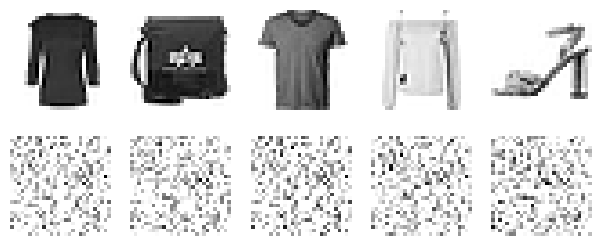

In [11]:
tf.random.set_seed(42) # extra code – ensures reproducibility on CPU

stacked_encoder = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="relu"),
    ]
)
stacked_decoder = keras.Sequential(
    [
        keras.layers.Input(shape=[10]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(28 * 28),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam()
)

plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 2s - loss: 0.7965 - val_loss: 0.6991 - 2s/epoch - 4ms/step
Epoch 2/10
430/430 - 1s - loss: 0.6836 - val_loss: 0.6649 - 1s/epoch - 3ms/step
Epoch 3/10
430/430 - 1s - loss: 0.6548 - val_loss: 0.6624 - 1s/epoch - 3ms/step
Epoch 4/10
430/430 - 1s - loss: 0.6278 - val_loss: 0.6219 - 1s/epoch - 3ms/step
Epoch 5/10
430/430 - 1s - loss: 0.6037 - val_loss: 0.6005 - 1s/epoch - 3ms/step
Epoch 6/10
430/430 - 1s - loss: 0.5979 - val_loss: 0.6105 - 1s/epoch - 3ms/step
Epoch 7/10
430/430 - 1s - loss: 0.5936 - val_loss: 0.5896 - 1s/epoch - 3ms/step
Epoch 8/10
430/430 - 1s - loss: 0.5762 - val_loss: 0.5751 - 1s/epoch - 3ms/step
Epoch 9/10
430/430 - 1s - loss: 0.5651 - val_loss: 0.5713 - 1s/epoch - 3ms/step
Epoch 10/10
430/430 - 1s - loss: 0.5860 - val_loss: 0.5810 - 1s/epoch - 3ms/step
1/1 [==============================] - 0s 12ms/step


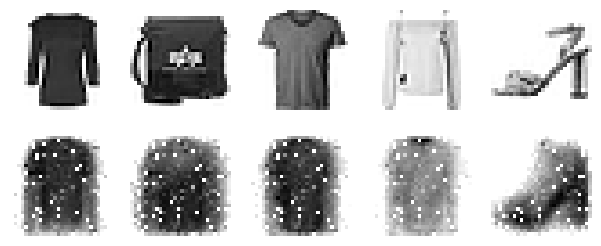

In [12]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
plot_reconstructions(stacked_ae, images=X_valid)

1/1 [==============================] - 0s 60ms/step


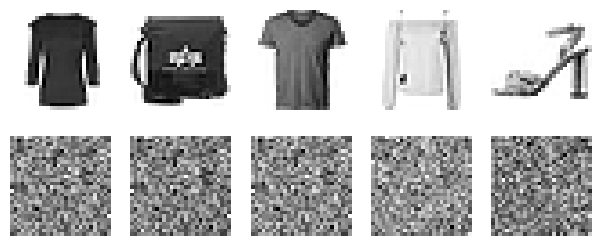

In [13]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

code_size = 9
stacked_encoder = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(14 * 14, activation="selu"),
        keras.layers.Dense(code_size, activation="selu"),
    ]
)
stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Input(shape=[code_size]),
        keras.layers.Dense(196, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
loss = "binary_crossentropy"
stacked_ae.compile(
    loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 2s - loss: 0.3967 - rounded_accuracy: 0.8351 - val_loss: 0.3573 - val_rounded_accuracy: 0.8770 - 2s/epoch - 5ms/step
Epoch 2/10
430/430 - 2s - loss: 0.3423 - rounded_accuracy: 0.8828 - val_loss: 0.3398 - val_rounded_accuracy: 0.8872 - 2s/epoch - 4ms/step
Epoch 3/10
430/430 - 2s - loss: 0.3335 - rounded_accuracy: 0.8896 - val_loss: 0.3348 - val_rounded_accuracy: 0.8923 - 2s/epoch - 4ms/step
Epoch 4/10
430/430 - 2s - loss: 0.3288 - rounded_accuracy: 0.8937 - val_loss: 0.3284 - val_rounded_accuracy: 0.8963 - 2s/epoch - 4ms/step
Epoch 5/10
430/430 - 2s - loss: 0.3248 - rounded_accuracy: 0.8975 - val_loss: 0.3237 - val_rounded_accuracy: 0.9007 - 2s/epoch - 4ms/step
Epoch 6/10
430/430 - 2s - loss: 0.3219 - rounded_accuracy: 0.8998 - val_loss: 0.3224 - val_rounded_accuracy: 0.9014 - 2s/epoch - 4ms/step
Epoch 7/10
430/430 - 2s - loss: 0.3200 - rounded_accuracy: 0.9012 - val_loss: 0.3247 - val_rounded_accuracy: 0.8945 - 2s/epoch - 4ms/step
Epoch 8/10
430/430 - 2s - loss: 0.

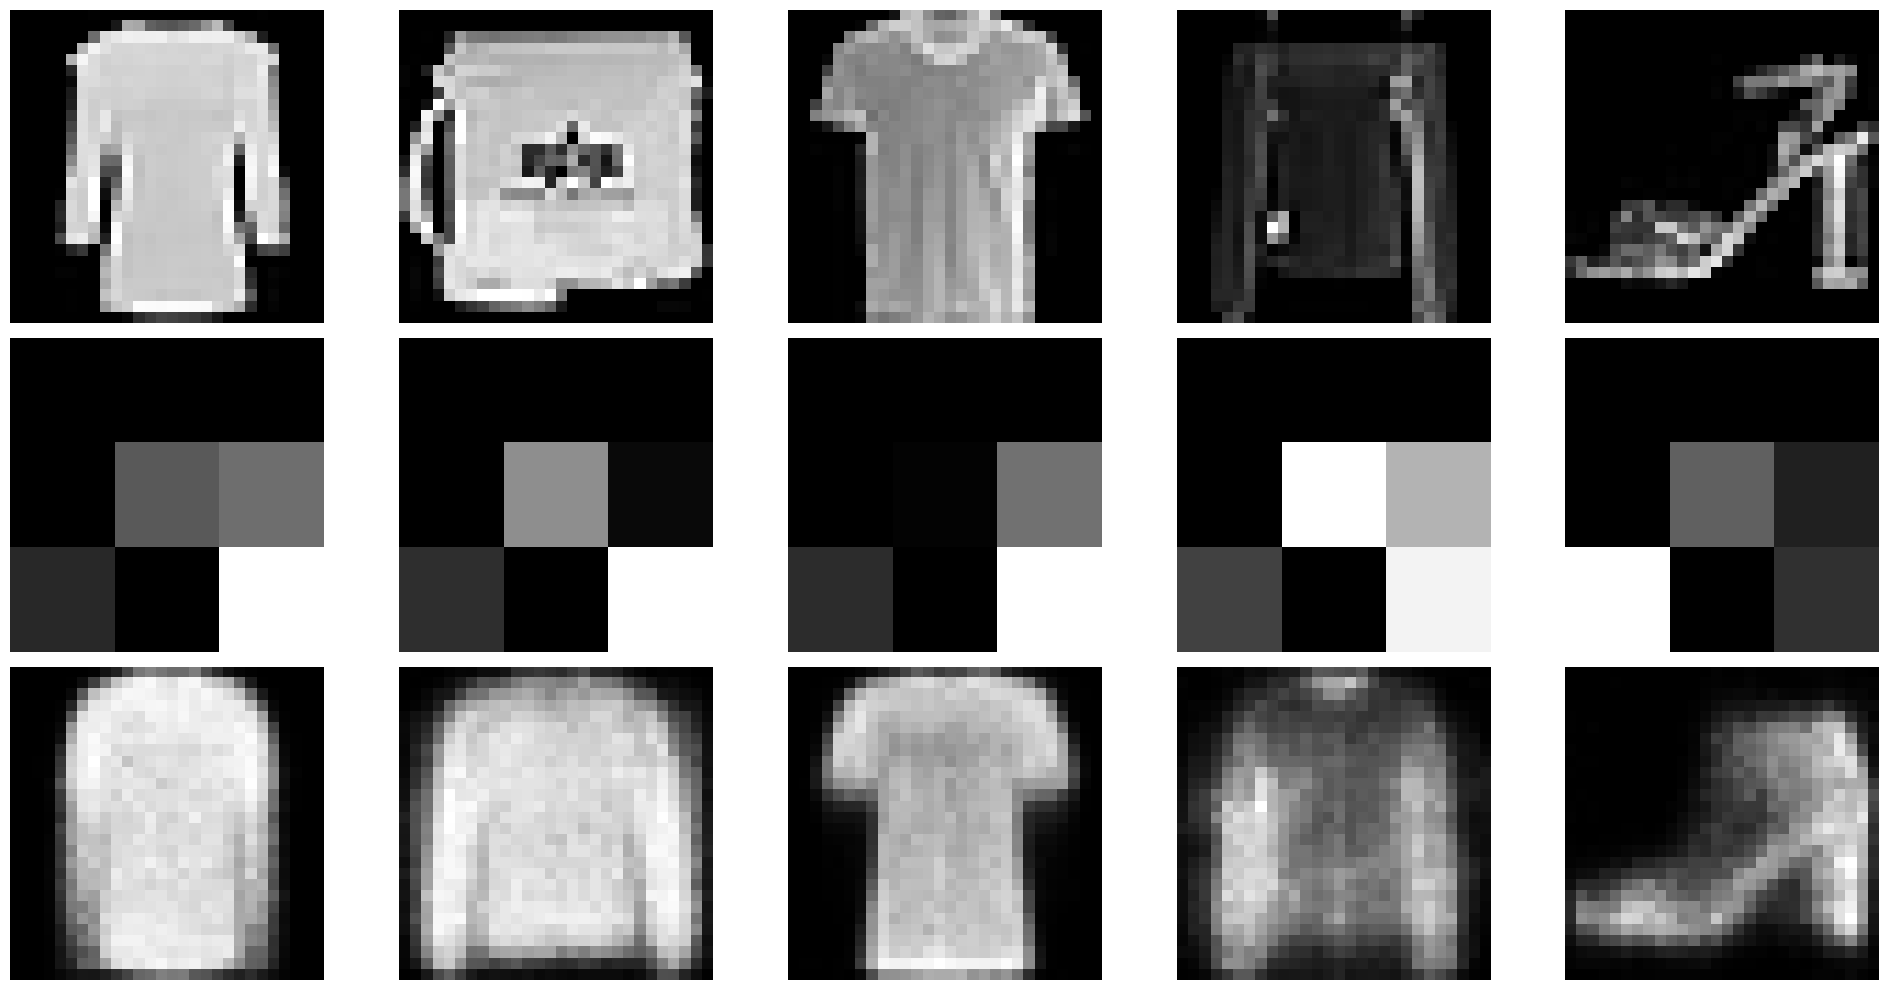

In [14]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(stacked_ae, X_valid, (3, 3), 5)

1/1 [==============================] - 0s 12ms/step


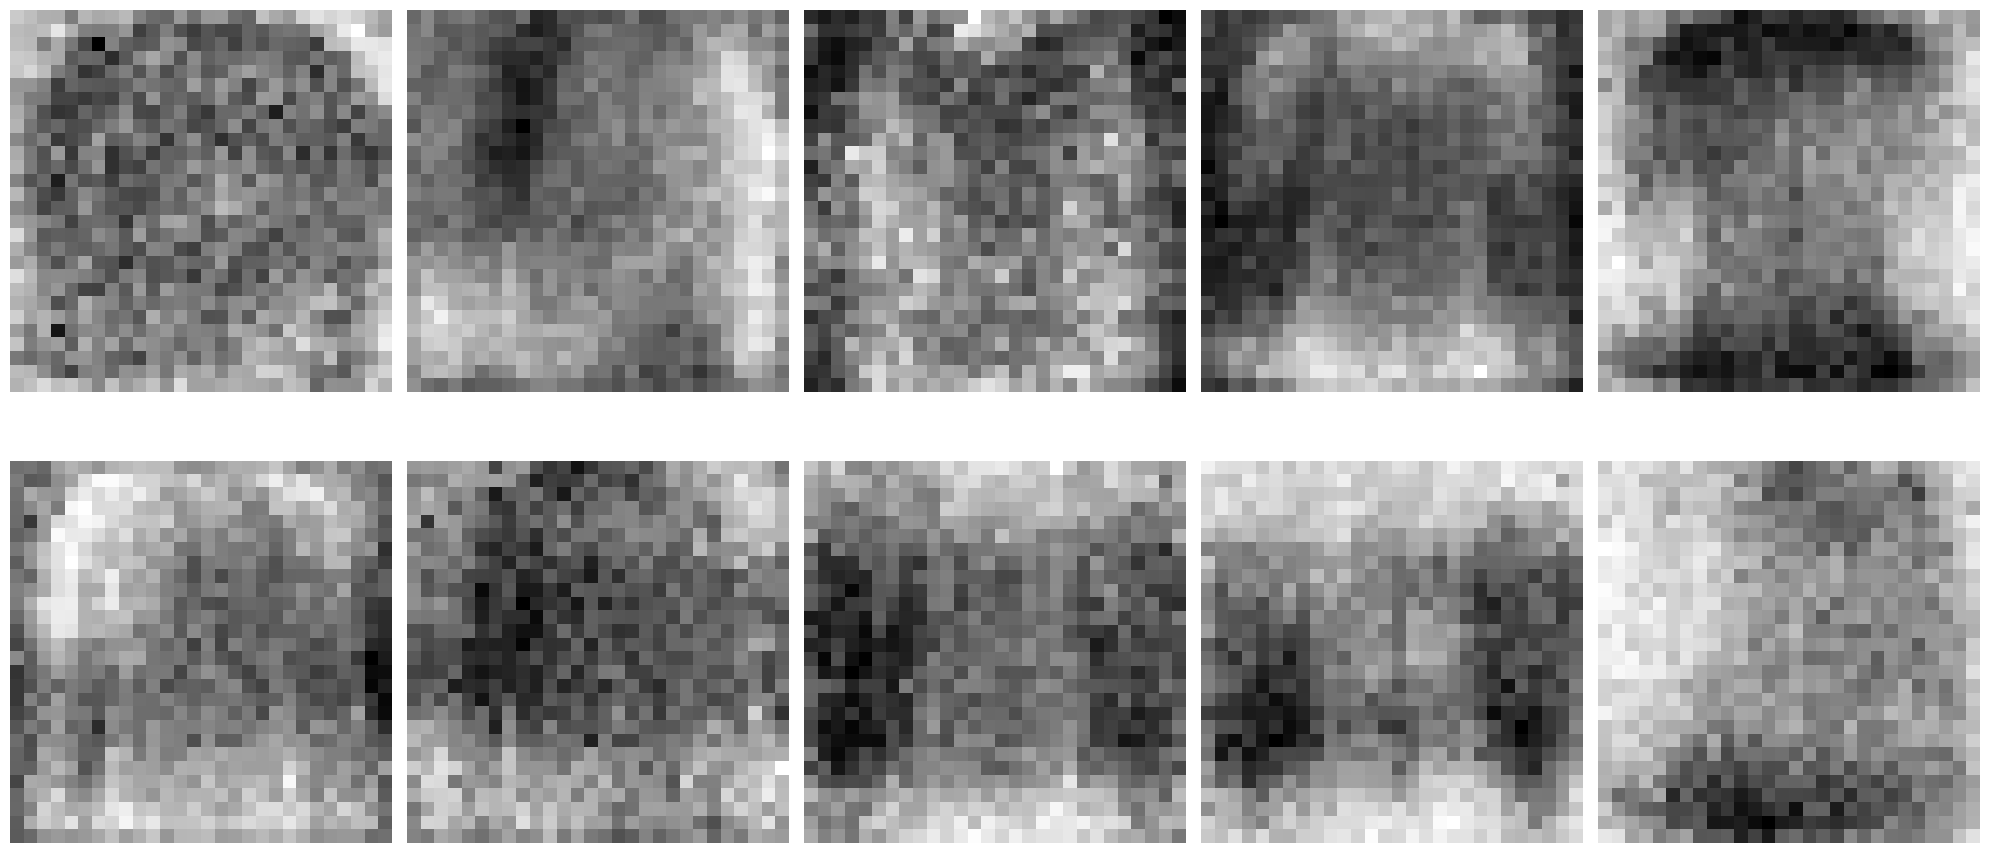

In [15]:
X_code = np.random.normal(size=(10, code_size))
images = stacked_decoder.predict(X_code)
plot_images(images, 2, 5)

1/1 [==============================] - 0s 13ms/step


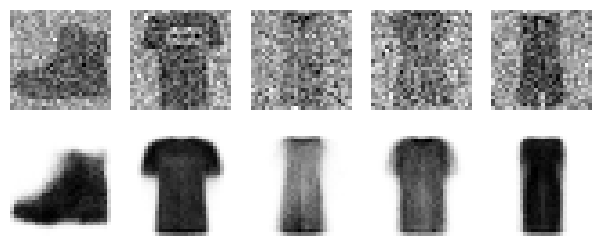

In [16]:
noise = keras.layers.GaussianNoise(0.3)
X_noise = noise(X_train, training=True).numpy()
plot_reconstructions(stacked_ae, images=X_noise[:10])

1/1 [==============================] - 0s 370ms/step


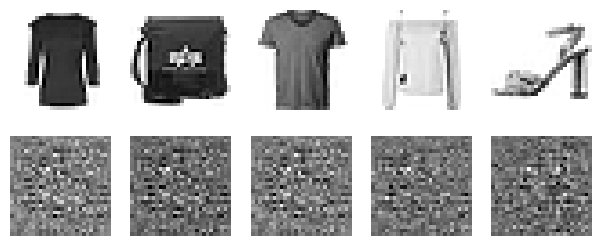

In [18]:
conv_encoder_2 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Reshape([28, 28, 1]),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(code_size)
    ]
)
conv_decoder_2 = keras.models.Sequential(
    [
        keras.layers.Dense(code_size * 64),
        keras.layers.Reshape([3, 3, 64], input_shape=[3 * 3 * 64]),
        keras.layers.Conv2DTranspose(
            32, kernel_size=3, strides=2, padding="VALID", activation="selu", input_shape=[3, 3, 64]
            ),
        keras.layers.Conv2DTranspose(
            16, kernel_size=3, strides=2, padding="SAME", activation="selu"
            ),
        keras.layers.Conv2DTranspose(
            1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"
            ),
        keras.layers.Reshape([28, 28])
    ]
)
conv_ae_2 = keras.models.Sequential([conv_encoder_2, conv_decoder_2])

conv_ae_2.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)

plot_reconstructions(conv_ae_2, images=X_valid)

Epoch 1/10
430/430 - 6s - loss: 0.3784 - rounded_accuracy: 0.8554 - val_loss: 0.3282 - val_rounded_accuracy: 0.8962 - 6s/epoch - 13ms/step
Epoch 2/10
430/430 - 4s - loss: 0.3181 - rounded_accuracy: 0.9036 - val_loss: 0.3139 - val_rounded_accuracy: 0.9101 - 4s/epoch - 10ms/step
Epoch 3/10
430/430 - 4s - loss: 0.3100 - rounded_accuracy: 0.9105 - val_loss: 0.3077 - val_rounded_accuracy: 0.9130 - 4s/epoch - 9ms/step
Epoch 4/10
430/430 - 4s - loss: 0.3062 - rounded_accuracy: 0.9134 - val_loss: 0.3032 - val_rounded_accuracy: 0.9191 - 4s/epoch - 9ms/step
Epoch 5/10
430/430 - 4s - loss: 0.3036 - rounded_accuracy: 0.9151 - val_loss: 0.3018 - val_rounded_accuracy: 0.9191 - 4s/epoch - 9ms/step
Epoch 6/10
430/430 - 4s - loss: 0.3019 - rounded_accuracy: 0.9163 - val_loss: 0.3022 - val_rounded_accuracy: 0.9181 - 4s/epoch - 9ms/step
Epoch 7/10
430/430 - 4s - loss: 0.3003 - rounded_accuracy: 0.9174 - val_loss: 0.3036 - val_rounded_accuracy: 0.9175 - 4s/epoch - 9ms/step
Epoch 8/10
430/430 - 4s - loss: 

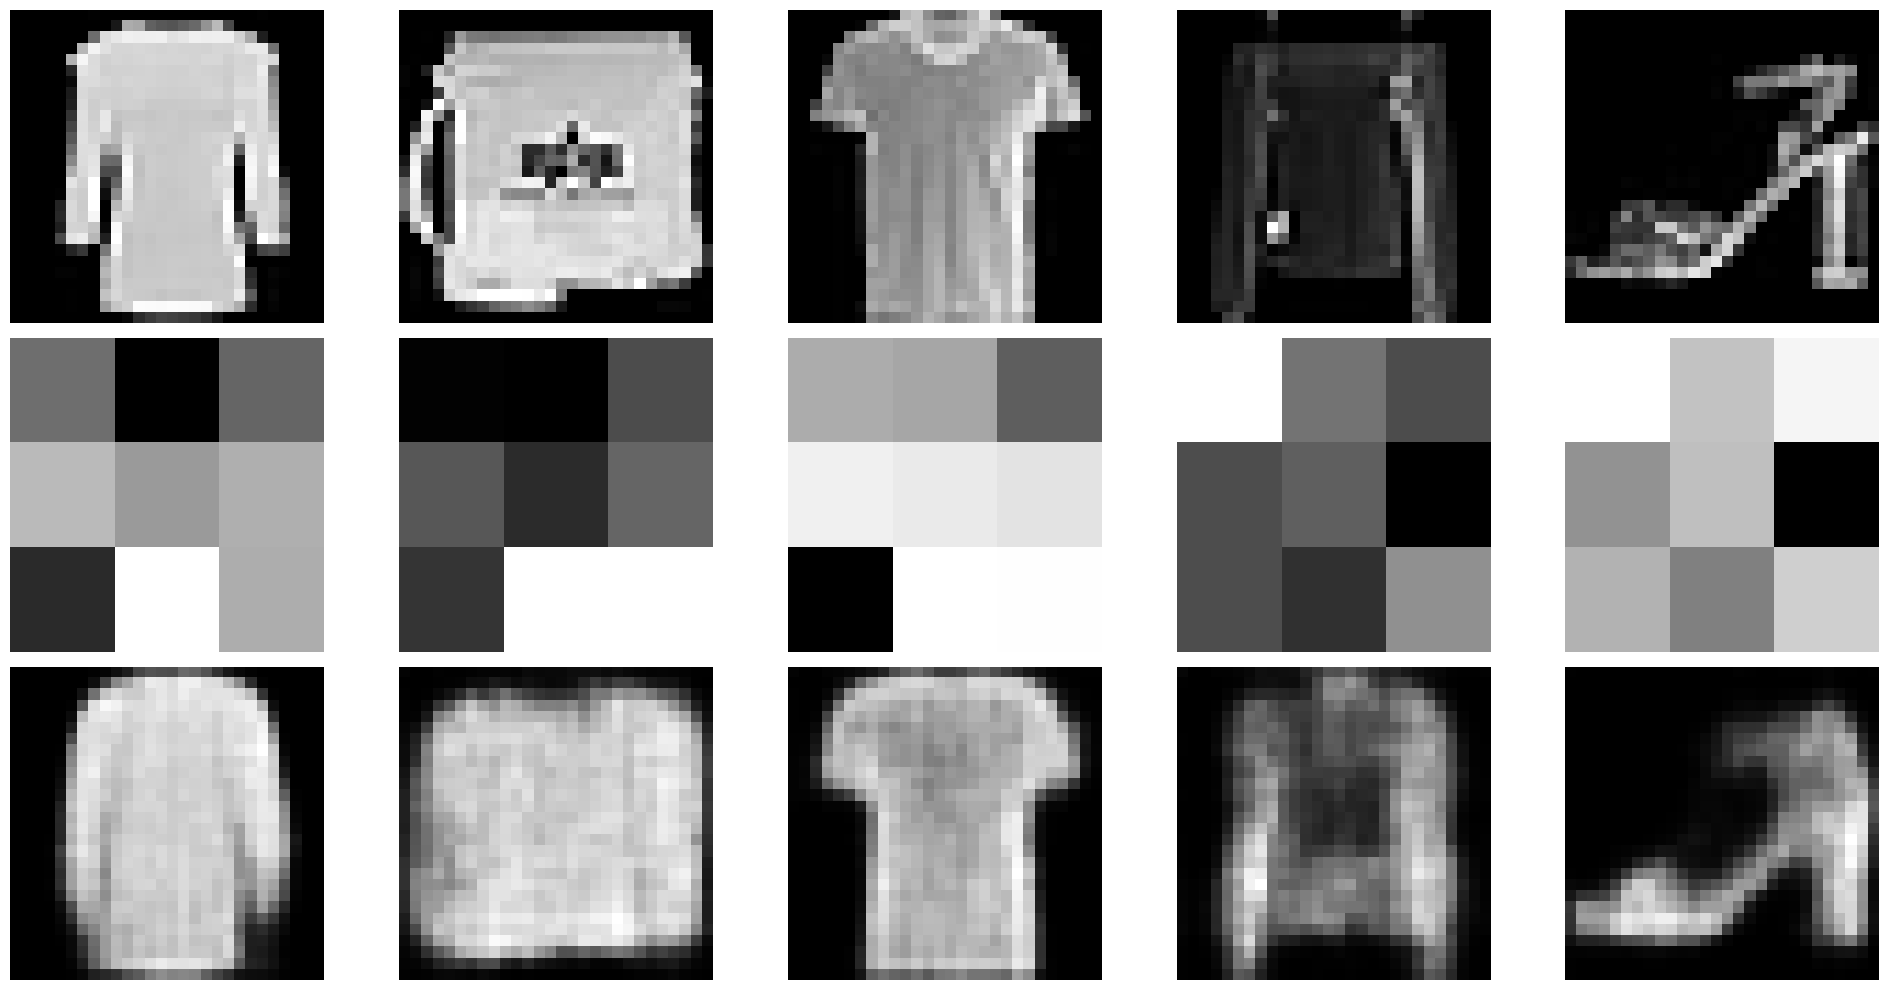

In [19]:
conv_ae_2.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(conv_ae_2, X_valid, (3, 3), 5)

1/1 [==============================] - 0s 108ms/step


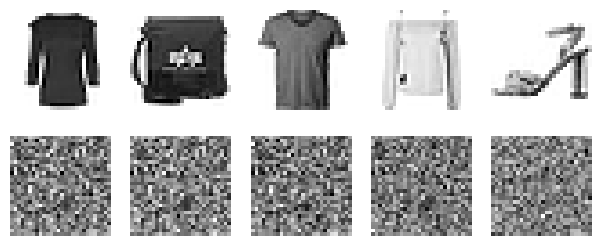

In [ ]:
code_size = 64
stacked_encoder1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(14 * 14, activation="selu"),
        keras.layers.Dense(code_size, activation="selu"),
    ]
)
stacked_decoder1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[code_size]),
        keras.layers.Dense(196, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae1 = keras.models.Sequential([stacked_encoder1, stacked_decoder1])
loss = "binary_crossentropy"
stacked_ae1.compile(
    loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)
plot_reconstructions(stacked_ae1, images=X_valid)

Epoch 1/20
430/430 - 3s - loss: 0.3731 - rounded_accuracy: 0.8572 - val_loss: 0.3263 - val_rounded_accuracy: 0.9005 - 3s/epoch - 7ms/step
Epoch 2/20
430/430 - 2s - loss: 0.3185 - rounded_accuracy: 0.9048 - val_loss: 0.3166 - val_rounded_accuracy: 0.9100 - 2s/epoch - 4ms/step
Epoch 3/20
430/430 - 2s - loss: 0.3097 - rounded_accuracy: 0.9124 - val_loss: 0.3075 - val_rounded_accuracy: 0.9167 - 2s/epoch - 4ms/step
Epoch 4/20
430/430 - 2s - loss: 0.3044 - rounded_accuracy: 0.9169 - val_loss: 0.3029 - val_rounded_accuracy: 0.9200 - 2s/epoch - 4ms/step
Epoch 5/20
430/430 - 2s - loss: 0.3005 - rounded_accuracy: 0.9205 - val_loss: 0.3009 - val_rounded_accuracy: 0.9240 - 2s/epoch - 4ms/step
Epoch 6/20
430/430 - 2s - loss: 0.2976 - rounded_accuracy: 0.9232 - val_loss: 0.2968 - val_rounded_accuracy: 0.9269 - 2s/epoch - 4ms/step
Epoch 7/20
430/430 - 2s - loss: 0.2948 - rounded_accuracy: 0.9258 - val_loss: 0.2974 - val_rounded_accuracy: 0.9204 - 2s/epoch - 4ms/step
Epoch 8/20
430/430 - 2s - loss: 0.

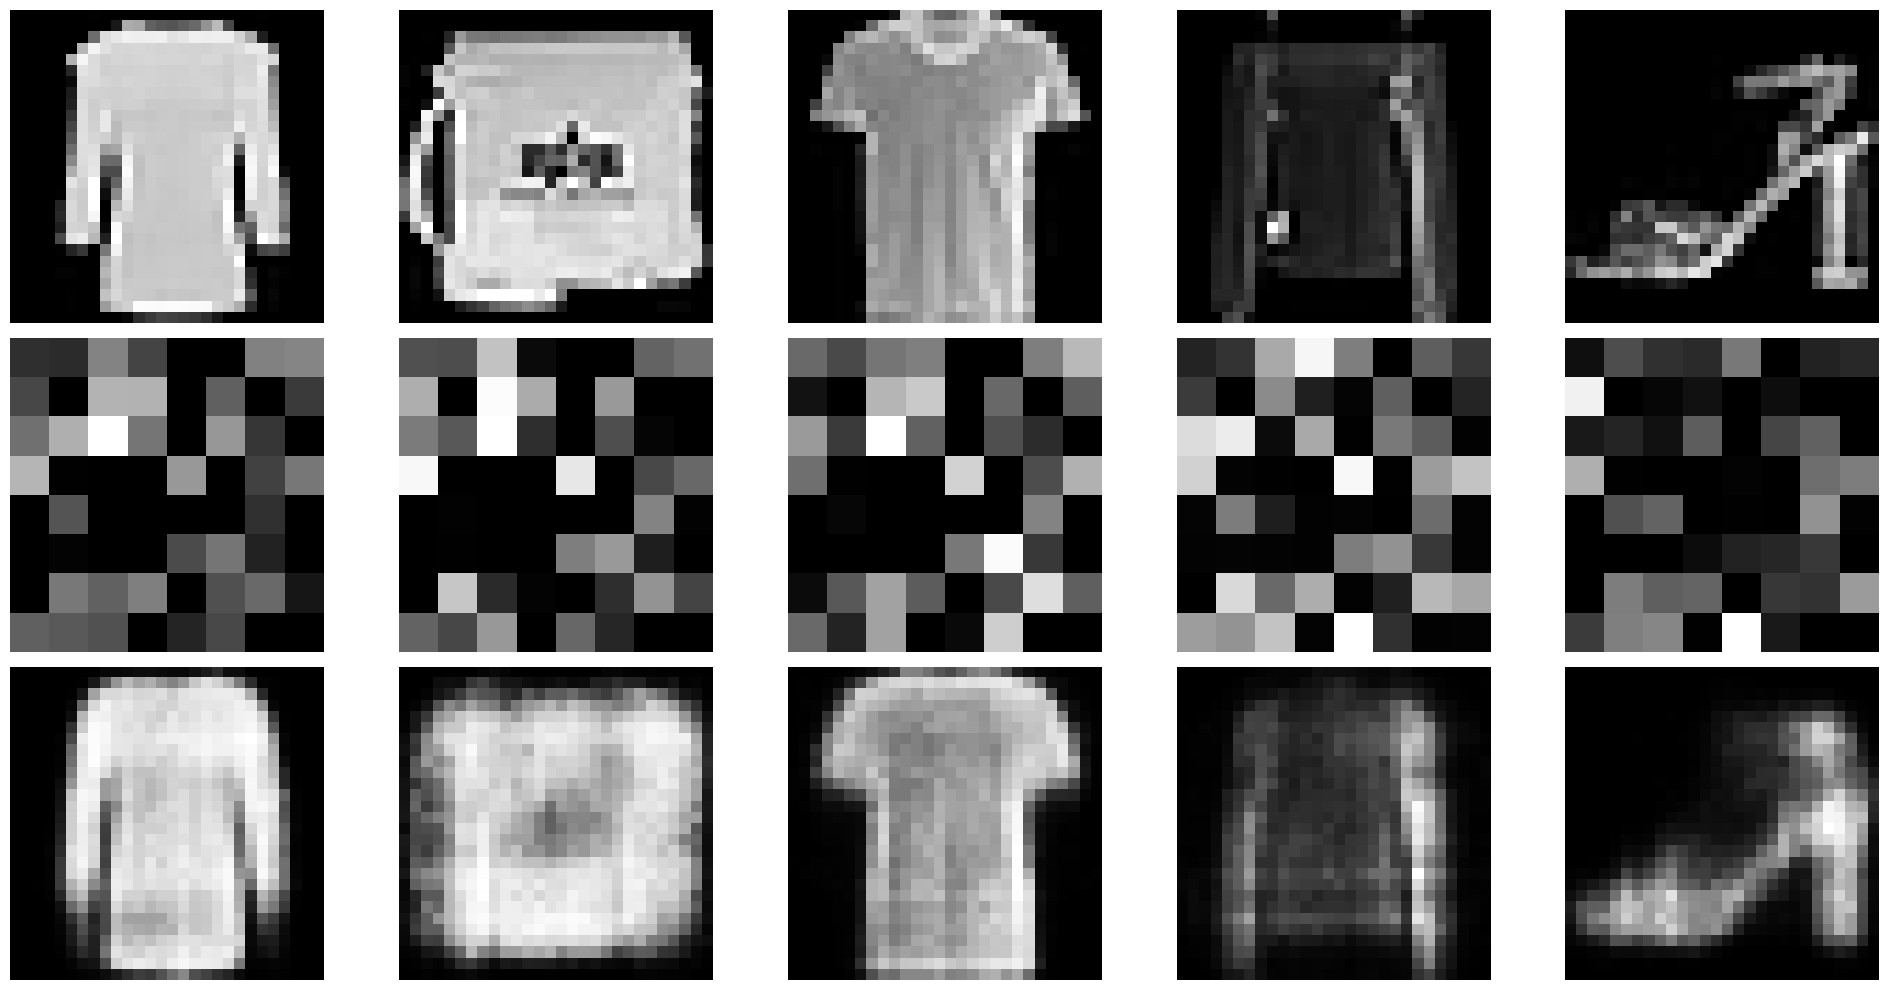

In [21]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.002,
    patience=2,
    mode="auto",
    verbose=True,
    restore_best_weights=True,
)
stacked_ae1.fit(
    X_train, X_train, epochs=20, validation_data=(X_valid, X_valid), verbose=2, batch_size=128, callbacks=[early_stopping]
)
show_reconstructions_code(stacked_ae1, X_valid, (8, 8), 5)


In [22]:
stacked_ae1.save("stacked_ae1.keras")

In [ ]:
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = tf.keras.datasets.mnist.load_data()
X_train_digits = tf.cast(mnist_images / 255, tf.float32)
y_train_digits = tf.cast(mnist_labels, tf.int64)